# Final Project

## Project Description
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

**Interconnect's services**

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

**Data Description**

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

In [1]:
#import relevant libraries to project
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

#visualization libraries
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

#sklearn
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score, ConfusionMatrixDisplay, auc, roc_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.utils import shuffle, resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

#gradient boosting
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#turn off warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
#load data
df_contract = pd.read_csv("contract.csv")
df_personal = pd.read_csv("personal.csv")
df_internet = pd.read_csv("internet.csv")
df_phone = pd.read_csv("phone.csv")

In [5]:
#inspect the data
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
df_contract['BeginDate'].value_counts().sort_values(ascending=False)

BeginDate
2014-02-01    366
2019-09-01    237
2019-10-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: count, Length: 77, dtype: int64

In [9]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


**Notes about the Contract Database:**

No missing values.

Preprocessing:
 - Change column names to underscore lowercase
 - Change BeginDate column to datetime
 - Change TotalCharges column to float64
 
 Feature Engineering:
 
 - One hot encode the PaymentMethod, PaperlessBilling, and Type columns.
 - Create a new column based on EndDate to say if customer has left or not left the service
 - Check seasonality for BeginDate column (month, day of the week, hour)
 - Perform class balancing

In [12]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [14]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


**Notes about the Personal Database:**

No missing values.

Preprocessing:

- Change column names to underscore lowercase

Feature Engineering:

- One hot encode the gender, Partner, and Dependents columns

In [17]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [19]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


**Notes about the Internet Database:**

No missing values, but 1526 fewer customer ID's then internet and personal DFs. This discrepancy is possibly explained by the fact that they did not sign up for internet service of any kind.

Preprocessing:
- Change column names to underscore lowercase

Feature Engineering:
- One hot encode all columns except for customer ID.

In [22]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [24]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Notes about the Phone Database:**

No missing values but there are 682 fewer customerID's than in the 

Preprocessing:

- Change column names to underscore lowercase

Feature Engineering:

- One hot encode the MultipleLines column

## Proposed Work Plan

**Goal:** Develop a model to predict user churn

Steps:
1. Download the data
<br>

2. Explore the data to determine how to treat the data in the preprocessing step
<br>

3. Perform preprocessing for the data
    - Merge the data from all dataframes to one main dataframe
    - Change column names to underscore lowercase format
    - Convert columns to desired data type
    
    
<br>

  4. Perform EDA to explore the data in depth
<br>

5. Feature Engineering
<br>
6. Test various classification models against a dummy benchmark. Logistic Regression will be used in this case. Use ROC-AUC and accuracy score for evaluation metrics. Fine tune models using cross-validation. Incorporate gradient boosting techniques. 
<br>
7. Evaluate final model on test set. 
<br>
8. Write conclusion

### Clarifying Questions

1. What is Interconnect's preferred balance of speed to accuracy in model selection?
2. Has the company applied the results of any previous models to their business? If so, what was the final outcome?
3. Who is the audience?
4. Is there any additional data the company can provide at the customer level? This would include data on the customer's location, additional personal information, etc.

## Data Preprocessing

In [31]:
#merge all 4 of the dataframes

#contract and personal
df = df_contract.merge(df_personal, on='customerID')

#merged and internet
df = df.merge(df_internet, how='outer', on='customerID')

#merged and phone
df = df.merge(df_phone, how='outer', on='customerID')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [33]:
#fill missing rows post-merge
df = df.fillna('Not signed up for other services')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Upon merging the 4 dataframes on the 'customer_id' column, we find that many columns have missing values due to customers not signing up for that column's particular service. For now, missing values have been filled in with 'Not signed up'.

In [36]:
#rename columns
df = df.rename(columns = {'customerID':'customer_id', 'BeginDate':'begin_date', 'EndDate':'end_date', 'Type':'type', 'PaperlessBilling':'paperless_billing', 'PaymentMethod':'payment_method', 'MonthlyCharges':'monthly_charges', 'TotalCharges':'total_charges', 'SeniorCitizen':'senior_citizen', 'Partner':'partner', 'Dependents':'dependents', 'InternetService':'internet_service', 'OnlineSecurity':'online_security', 'OnlineBackup':'online_backup', 'DeviceProtection':'device_protection', 'TechSupport':'tech_support', 'StreamingTV':'streaming_tv', 'StreamingMovies':'streaming_movies', 'MultipleLines':'multiple_lines'})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

In [38]:
#change column data types

#convert 'begin_date' column to datetime 
df['begin_date'] = pd.to_datetime(df['begin_date'])

#convert 'total_charges' column to float64 
display((df['total_charges'] == ' ').sum()) #found 11 rows in the column with empty values. 
df['total_charges'].replace(" ", np.nan, inplace=True) #replace empty values with NaN to prepare to drop these rows
df = df.dropna(subset=['total_charges']) #drop 11 rows with NaN values in 'total_charges' column to convert to float64. 11 rows is much smaller than 5% of total data so its ok to drop these.
df['total_charges'] = df['total_charges'].astype('float64') #convert column to float64 

df.info()


11

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_backup

Because the customer_id column will not affect the models, it is no longer useful after the merge and can be dropped from the merged df. 

In [41]:
#drop 'customer_id' column
df = df.drop('customer_id', axis=1)

In [43]:
df.head(25)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Not signed up for other services
1,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Not signed up for other services
4,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,Not signed up for other services
8,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


## EDA

In [46]:
#create a new column based on 'end_date' to say if customer has left or not left the service which will serve as the target
df['customer_churn'] = np.where(df['end_date'] == 'No', 1, 0) # 1 is no churn, 0 is churn

#drop 'end_date' column
df = df.drop(['end_date'], axis=1)

df.head(20)

,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_churn
0,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Not signed up for other services,1
1,2017-04-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1
2,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
3,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Not signed up for other services,1
4,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0
5,2019-03-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,2018-04-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,1
7,2019-04-01,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,Not signed up for other services,1
8,2017-07-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,2014-12-01,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No,1


Percentage of customers in the dataframe that did not churn: 73.42150170648463


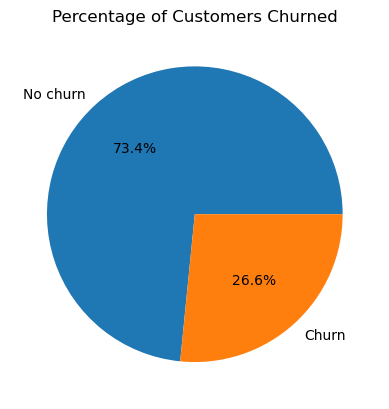

In [19]:
#checking for a class imbalance
classes = len(df[df['customer_churn'] == 1]) / len(df['customer_churn']) * 100
print('Percentage of customers in the dataframe that did not churn:', classes)

labels = ['No churn', 'Churn']
fig, ax = plt.subplots()
ax.pie(df['customer_churn'].value_counts(), labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Customers Churned')
plt.show()

**Class Imbalance**

We can see from the above chart that a class imbalance occurs in our target column, 'customer_churn'. Recall that 0 represents customers who have left the service. Specifically, customers who were loyal to the company significantly outweigh the customers who churned. The problem with this is that any model trained on this data will not perform nearly as well on the smaller, or minority class. This may lead to highly inaccurate predictions of those customers who will churn. 

Solution: Upsampling. Upsampling will generate additional synthetic data points in the minority class, which in this case is customers who have churned.



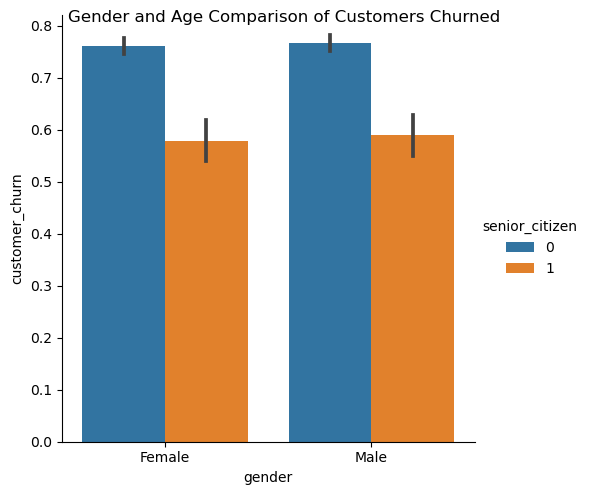

In [49]:
#visualize the churn of male-female customers and senior citizens
g = sns.catplot(data=df, x="gender", y="customer_churn", hue='senior_citizen', kind="bar")

g.fig.suptitle('Gender and Age Comparison of Customers Churned')
plt.show()

From the above plot, we can see that while the male-female ratio of customers who churned is about equal, there is a larger proportion of customers that churned who are identified as senior citizens. Lets look further into this to find out if senior citizens constitute a meaningful proportion of overall customer base.

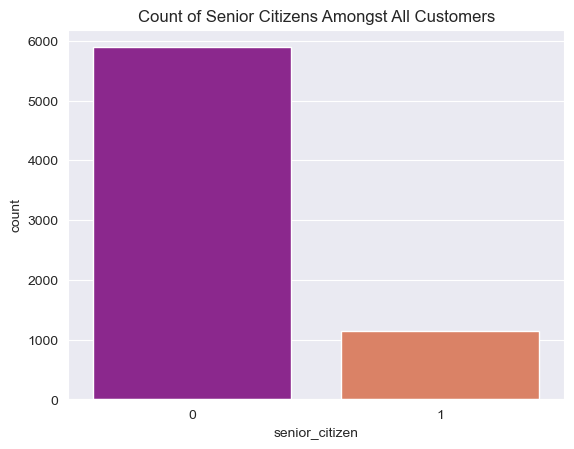

In [51]:
#countplot of senior citizens
sns.set_style('darkgrid')
sns.countplot(x='senior_citizen', data=df, palette='plasma')
plt.title('Count of Senior Citizens Amongst All Customers')
plt.show()

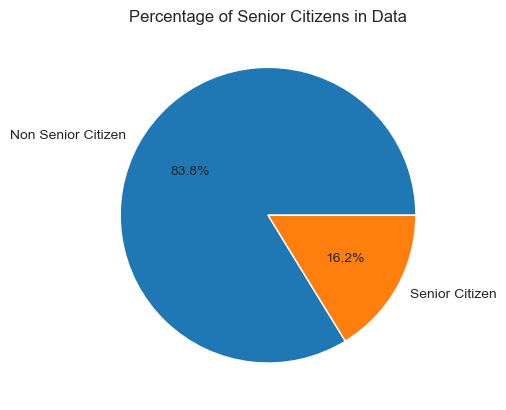

In [53]:
labels = ['Non Senior Citizen', 'Senior Citizen']
fig, ax = plt.subplots()
ax.pie(df['senior_citizen'].value_counts(), labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Senior Citizens in Data')
plt.show()

It appears that the number of senior citizen customers is just over 1100, representing 16.2% of our data.

internet_service                  customer_churn
DSL                               1                 1957
                                  0                  459
Fiber optic                       1                 1799
                                  0                 1297
Not signed up for other services  1                 1407
                                  0                  113
Name: count, dtype: int64

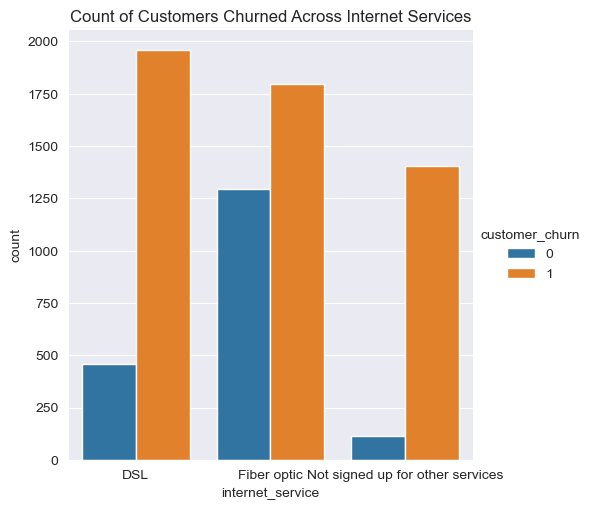

In [55]:
#visualize distribution of churned customers across internet services
int = df.groupby('internet_service')['customer_churn'].value_counts()
display(int)

sns.catplot(data=df, x='internet_service', hue='customer_churn', kind='count')
plt.title('Count of Customers Churned Across Internet Services')
plt.show()

It appears that those customers who signed up for fiber optic internet service not only had the largest percentage of churn within that category, but also the largest number of customers who churned across all three categories of internet service.

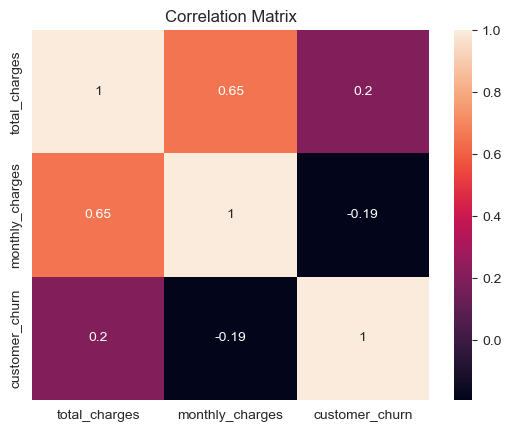

In [24]:
corr_matrix = df[['total_charges', 'monthly_charges', 'customer_churn']].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

**Feature Engineering**

In [57]:
#create three additional features from the 'begin_date' column

df['begin_year'] = df['begin_date'].dt.year
df['begin_month'] = df['begin_date'].dt.month
df['begin_day_of_week'] = df['begin_date'].dt.dayofweek

df = df.drop({'begin_date'}, axis=1) #drop begin_date column from df

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   gender             7032 non-null   object 
 6   senior_citizen     7032 non-null   int64  
 7   partner            7032 non-null   object 
 8   dependents         7032 non-null   object 
 9   internet_service   7032 non-null   object 
 10  online_security    7032 non-null   object 
 11  online_backup      7032 non-null   object 
 12  device_protection  7032 non-null   object 
 13  tech_support       7032 non-null   object 
 14  streaming_tv       7032 non-null   object 
 15  streaming_movies   7032 non-null   object 
 16  multiple_lines     7032 non-n

,begin_year,customer_churn,count
0,2013,0,8
1,2014,1,1246
2,2014,0,98
3,2015,1,729
4,2015,0,123
5,2016,1,618
6,2016,0,145
7,2017,1,646
8,2017,0,199
9,2018,1,715


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   begin_year      14 non-null     int32
 1   customer_churn  14 non-null     int32
 2   count           14 non-null     int64
dtypes: int32(2), int64(1)
memory usage: 356.0 bytes


None

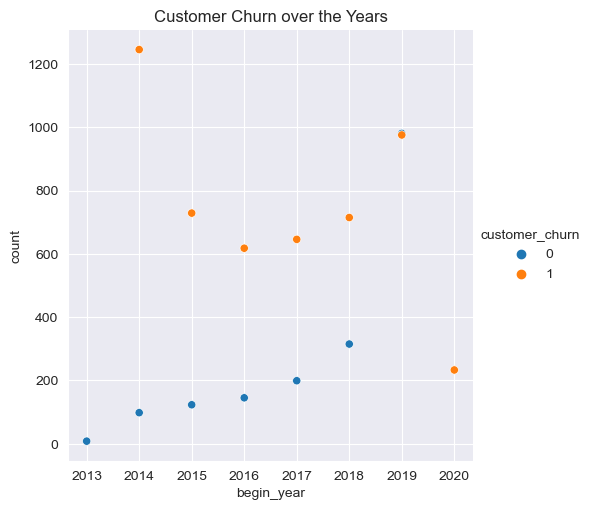

In [61]:
#check 'begin_year' column for relationship to 'customer_churn'
year_df = df.groupby('begin_year')['customer_churn'].value_counts().reset_index()
display(year_df)
display(year_df.info())

sns.relplot(data=year_df, x='begin_year', y='count', hue='customer_churn')
plt.title('Customer Churn over the Years')
plt.show()

Starting from 2013, there is an increase in the total # of customers who leave interconnect based on their start date. This may be due to a possible service change in 2018 or 2019, as the majority of customers who are current are longer term customers. The 2018 and 2019 start dates saw the highest number of customers who churned, with a large majority of total customers churned having begun their contracts with interconnect in 2019. 

End date was not of material interest here because the data only provided us with 4 end dates for customers that did infact churn, each of which with a close to equal percentage of occurances.

,begin_month,customer_churn,count
0,1,1,529
1,1,0,94
2,2,1,671
3,2,0,122
4,3,1,483
5,3,0,107
6,4,1,413
7,4,0,98
8,5,1,368
9,5,0,126


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   begin_month     24 non-null     int32
 1   customer_churn  24 non-null     int32
 2   count           24 non-null     int64
dtypes: int32(2), int64(1)
memory usage: 516.0 bytes


None

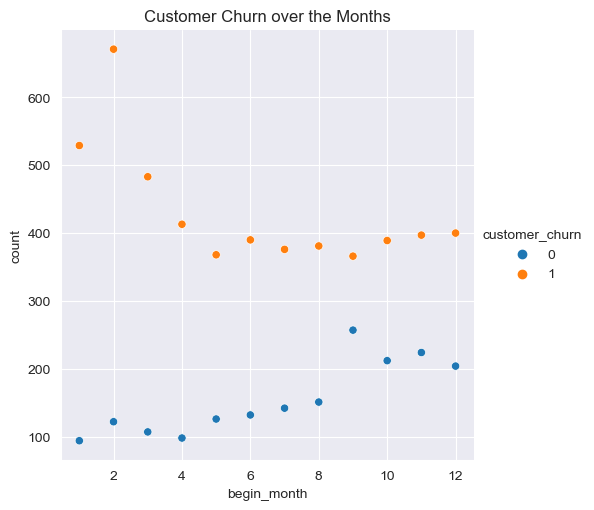

In [64]:
#check 'begin_month' column for relationship to 'customer churn'
month_df = df.groupby('begin_month')['customer_churn'].value_counts().reset_index()
display(month_df)
display(month_df.info())

sns.relplot(data=month_df, x='begin_month', y='count', hue='customer_churn')
plt.title('Customer Churn over the Months')
plt.show()

Of note is that a large number of customers churned who had begun their contracts in fourth quarter of the year, particularly in september and in the later months. 

,begin_day_of_week,customer_churn,count
0,0,1,617
1,0,0,230
2,1,1,672
3,1,0,276
4,2,1,783
5,2,0,180
6,3,1,654
7,3,0,219
8,4,1,723
9,4,0,345


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   begin_day_of_week  14 non-null     int32
 1   customer_churn     14 non-null     int32
 2   count              14 non-null     int64
dtypes: int32(2), int64(1)
memory usage: 356.0 bytes


None

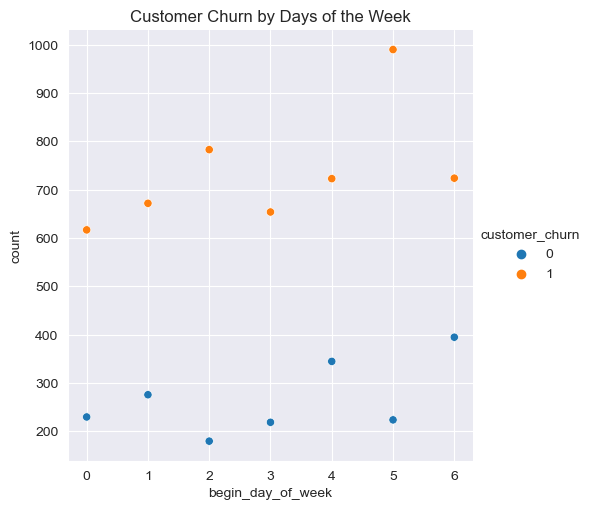

In [66]:
#check 'begin_day_of_week' column for relationship to 'customer_churn'
day_df = df.groupby('begin_day_of_week')['customer_churn'].value_counts().reset_index()
display(day_df)
display(day_df.info())

sns.relplot(data=day_df, x='begin_day_of_week', y='count', hue='customer_churn')
plt.title('Customer Churn by Days of the Week')
plt.show()

**Conclusion:** 

Customers who began their service with Interconnect on Thursdays and Saturdays, between September and December, and in 2018 and 2019 represent most of the customers who are no longer in contract with Interconnect. 

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   gender             7032 non-null   object 
 6   senior_citizen     7032 non-null   int64  
 7   partner            7032 non-null   object 
 8   dependents         7032 non-null   object 
 9   internet_service   7032 non-null   object 
 10  online_security    7032 non-null   object 
 11  online_backup      7032 non-null   object 
 12  device_protection  7032 non-null   object 
 13  tech_support       7032 non-null   object 
 14  streaming_tv       7032 non-null   object 
 15  streaming_movies   7032 non-null   object 
 16  multiple_lines     7032 non-n

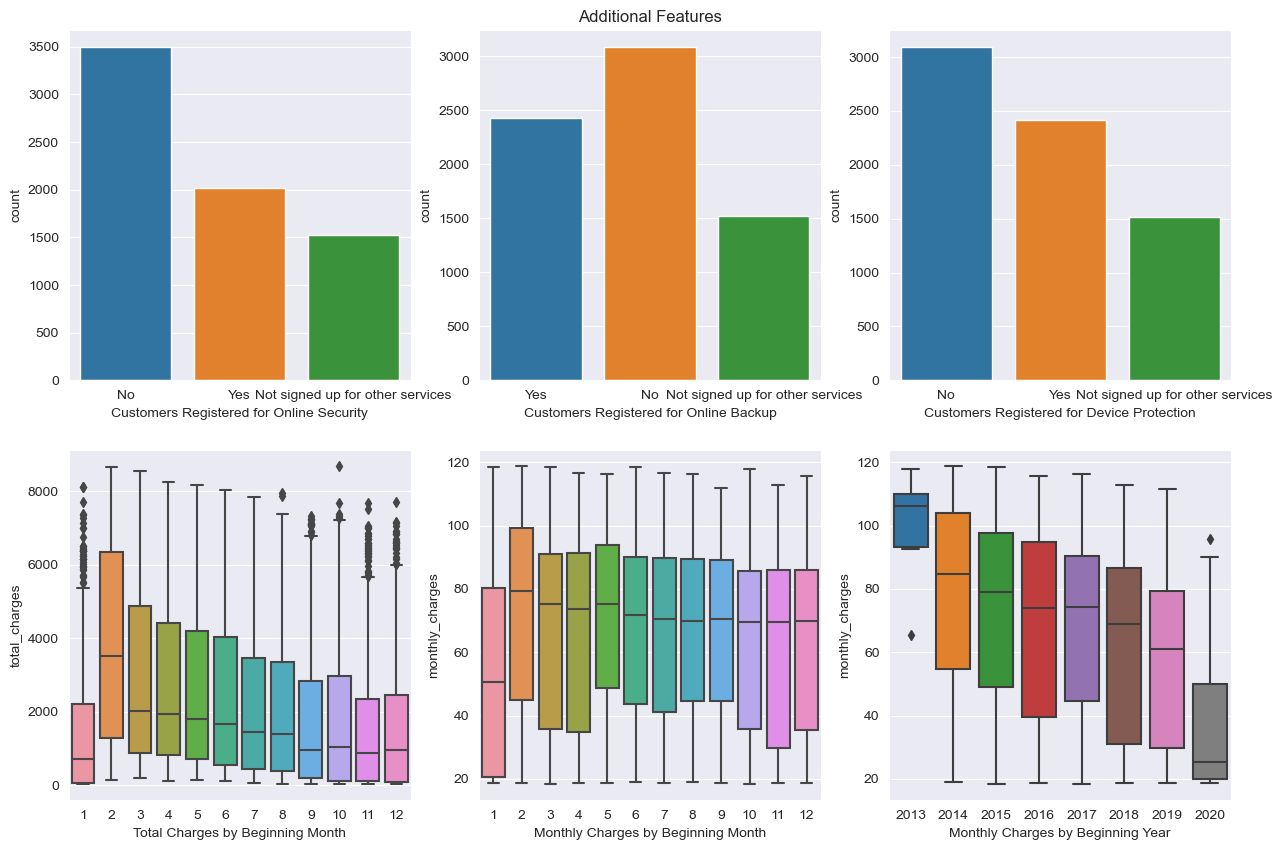

In [31]:
#Analyzing additional features
fig = plt.figure(figsize = (15, 10))

ax1 = fig.add_subplot(2,3,1)
sns.countplot(data=df, x='online_security', ax=ax1)
plt.xlabel('Customers Registered for Online Security')

ax2 = fig.add_subplot(2,3,2)
plt.title('Additional Features')
sns.countplot(data=df, x='online_backup', ax=ax2)
plt.xlabel('Customers Registered for Online Backup')

ax3 = fig.add_subplot(2,3,3)
sns.countplot(data=df, x='device_protection', ax=ax3)
plt.xlabel('Customers Registered for Device Protection')

ax4 = fig.add_subplot(2,3,4)
sns.boxplot(data=df, x='begin_month', y='total_charges', ax=ax4)
plt.xlabel('Total Charges by Beginning Month')

ax5 = fig.add_subplot(2,3,5)
sns.boxplot(data=df, x='begin_month', y='monthly_charges', ax=ax5)
plt.xlabel('Monthly Charges by Beginning Month')

ax6 = fig.add_subplot(2,3,6)
sns.boxplot(data=df, x='begin_year', y='monthly_charges', ax=ax6)
plt.xlabel('Monthly Charges by Beginning Year')

plt.show()

While total charges decreased for those signing up later in the calendar year, median monthly charges remained largely unchanged across all 12 months, aside for them being lower for January sign ups. This could be explained by discounts being offered by the company in the new year. Additionally, median monthly charges by contract start year are pretty consistent, aside for a steep price drop in 2020. This could be either due to the decrease in customers because of the large churns in 2018 and 2019, or the company actively lowering prices in 2020 to attract new customers in light of the churn.

### Encoding

In [71]:
#one hot encode the 'payment_method', 'paperless_billing', and 'type' columns.
df = pd.get_dummies(df, columns=['payment_method', 'paperless_billing', 'type'])

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   monthly_charges                           7032 non-null   float64
 1   total_charges                             7032 non-null   float64
 2   gender                                    7032 non-null   object 
 3   senior_citizen                            7032 non-null   int64  
 4   partner                                   7032 non-null   object 
 5   dependents                                7032 non-null   object 
 6   internet_service                          7032 non-null   object 
 7   online_security                           7032 non-null   object 
 8   online_backup                             7032 non-null   object 
 9   device_protection                         7032 non-null   object 
 10  tech_support                             

In [75]:
#label encoding
le = LabelEncoder()
categ = ['gender','senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

df[categ] = df[categ].apply(le.fit_transform)

In [77]:
df.head(25)

,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,...,begin_day_of_week,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,paperless_billing_No,paperless_billing_Yes,type_Month-to-month,type_One year,type_Two year
0,29.85,29.85,0,0,1,0,0,0,2,0,...,2,False,False,True,False,False,True,True,False,False
1,56.95,1889.50,1,0,0,0,0,2,0,2,...,5,False,False,False,True,True,False,False,True,False
2,53.85,108.15,1,0,0,0,0,2,2,0,...,1,False,False,False,True,False,True,True,False,False
3,42.30,1840.75,1,0,0,0,0,2,0,2,...,6,True,False,False,False,True,False,False,True,False
4,70.70,151.65,0,0,0,0,1,0,0,0,...,6,False,False,True,False,False,True,True,False,False
5,99.65,820.50,0,0,0,0,1,0,0,2,...,4,False,False,True,False,False,True,True,False,False
6,89.10,1949.40,1,0,0,1,1,0,2,0,...,6,False,True,False,False,False,True,True,False,False
7,29.75,301.90,0,0,0,0,0,2,0,0,...,0,False,False,False,True,True,False,True,False,False
8,104.80,3046.05,0,0,1,0,1,0,0,2,...,5,False,False,True,False,False,True,True,False,False
9,56.15,3487.95,1,0,0,1,0,2,2,0,...,0,True,False,False,False,True,False,False,True,False


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   monthly_charges                           7032 non-null   float64
 1   total_charges                             7032 non-null   float64
 2   gender                                    7032 non-null   int32  
 3   senior_citizen                            7032 non-null   int64  
 4   partner                                   7032 non-null   int32  
 5   dependents                                7032 non-null   int32  
 6   internet_service                          7032 non-null   int32  
 7   online_security                           7032 non-null   int32  
 8   online_backup                             7032 non-null   int32  
 9   device_protection                         7032 non-null   int32  
 10  tech_support                             

### Splitting Data

**Features and Target**

In [83]:
features = df.drop('customer_churn', axis=1)
target = df['customer_churn']

In [85]:
#splitting data into training, validation, and test sets at a ratio of 60:20:20

#split training and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)

#split validation set
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=12345, stratify=target_train)

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(features_test.shape)

(4218, 26)
(4218,)
(1407, 26)
(1407, 26)


### Feature Scaling

In [39]:
numeric = ['monthly_charges', 'total_charges', 'begin_year','begin_month', 'begin_day_of_week']

def scaling(features_train, features_valid, features_test):
    scaler = MinMaxScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric]) 
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    return features_train, features_valid, features_test

scaling(features_train, features_valid, features_test)

(      monthly_charges  total_charges  gender  senior_citizen  partner  \
 95           0.604582       0.104836       0               0        0   
 4652         0.013944       0.052995       0               0        0   
 5571         0.613048       0.564964       1               0        1   
 320          0.639442       0.499801       0               1        0   
 303          0.418825       0.471979       0               0        1   
 ...               ...            ...     ...             ...      ...   
 5430         0.536853       0.089477       1               0        0   
 5954         0.366036       0.132322       1               0        0   
 948          0.804781       0.389680       1               1        0   
 6255         0.919323       0.875986       1               1        1   
 6756         0.712151       0.221563       1               1        1   
 
       dependents  internet_service  online_security  online_backup  \
 95             0                 1    

### Upsampling the Data
We will now address the class imbalance by upsampling the data.

In [89]:
#function to upsample the data
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_ones] + [features_zeros]  * repeat)
    target_upsampled = pd.concat([target_ones] + [target_zeros] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [91]:
#apply upsample function to training set 
upsample_features_train, upsample_target_train = upsample(features_train, target_train, 3)

Balance of Classes:
customer_churn
0    0.520588
1    0.479412
Name: proportion, dtype: float64


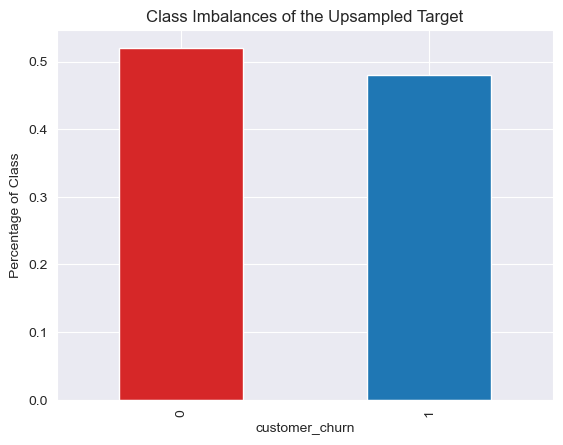

In [93]:
#re-examine class balances after upsampling
class_balance_upsampled = upsample_target_train.value_counts(normalize=True)
print('Balance of Classes:')
print(class_balance_upsampled)

fig, ax = plt.subplots()

bar_colors = ['tab:red', 'tab:blue']

class_balance_upsampled.plot.bar(ylabel='Percentage of Class', title='Class Imbalances of the Upsampled Target', color=bar_colors)


plt.show()

Upon further review, the class imbalance is much closer to at 52% to 47%, enabeling us to move forward with our model training

## Model Training

**Evaluation Metrics** 

Our primary evaluation metric for the models will be AUC-ROC score. This plot of its curve will give a score that evaluates the model's ability to predict customers who will churn and customers who will remain loyal to interconnect.

The secondary evaluation metric for our models is accuracy score. The accuracy score is a percentage of predictions that were made correctly by the model.

In [97]:
#evaluation function to score and plot auc-roc

#calculate auc-roc score
def auc_roc(model, features, target):
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target, probabilities_one_valid)
    print('AUC - ROC Score:', auc_roc)
    
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    
    #calculate accuracy score on training set
    train_predictions = model.predict(features)
    train_accuracy = accuracy_score(target, train_predictions)
    print("Accuracy Score for the Training Set:", train_accuracy)
    
    #plot auc-roc curve
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    return

**Dummy Model**

The purpose of using a dummy model is to serve as a benchmark from which to compare other models to.

Dummy Classifier:

AUC - ROC Score: 0.5
Accuracy Score for the Training Set: 0.4861407249466951


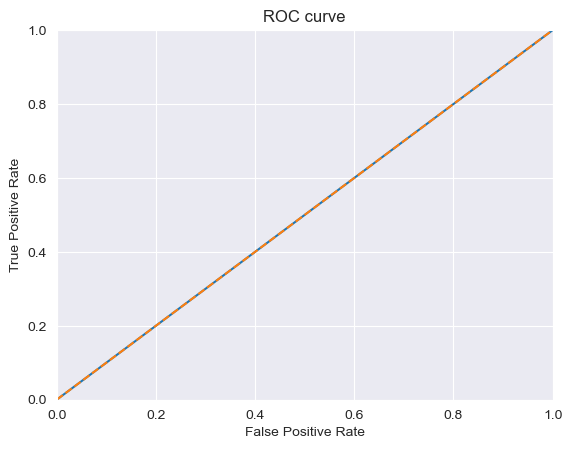

In [100]:
#initialize dummy model
dummy_clf = DummyClassifier(strategy='uniform') #strategy is uniform because data is now balanced
dummy_clf.fit(upsample_features_train, upsample_target_train) #fit the dummy classifier to upsampled training set
dummy_pred = dummy_clf.predict(features_valid)

print('Dummy Classifier:')
print('')

#evaluate the dummy model
auc_roc(dummy_clf, features_valid, target_valid)



With an AUC-ROC score of 0.5, the dummy classifer has no ability to seperate between the two classes. 

**Logistic Regression**

In [102]:
%%time
#initialize the logistic regression model
lr = LogisticRegression(random_state=12345)

#parameter grid
lr_params = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'],
    'fit_intercept': [True, False],
    'n_jobs': list(range(1,10))
}

lr_clf = GridSearchCV(lr, lr_params, scoring='roc_auc', n_jobs=-1, cv=2)
lr_clf.fit(upsample_features_train, upsample_target_train)

CPU times: total: 3.45 s
Wall time: 17.5 s


GridSearchCV(cv=2, estimator=LogisticRegression(random_state=12345), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='roc_auc')

In [103]:
print("Tuned Hyperparameters :", lr_clf.best_params_)
print("Accuracy :",lr_clf.best_score_)

Tuned Hyperparameters : {'fit_intercept': False, 'n_jobs': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.832532115555654


AUC - ROC Score: 0.8521310134544003
Accuracy Score for the Training Set: 0.736318407960199


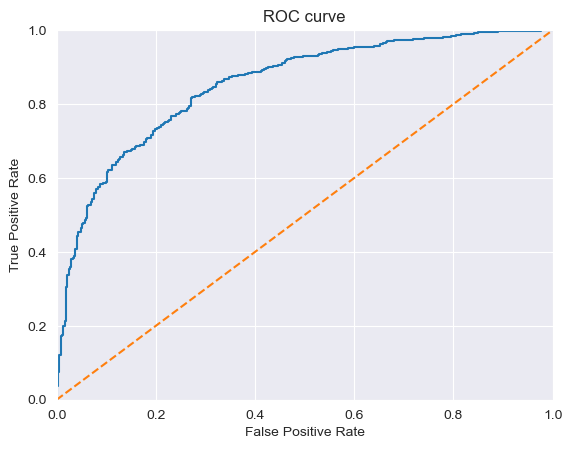

In [104]:
auc_roc(lr_clf, features_valid, target_valid)

**KNN**

In [108]:
%%time
#Initialize KNN model
knn = KNeighborsClassifier()

#parameter grid
knn_params = {'n_neighbors': (5, 20, 100, 200, 500),
        'p':np.arange(1,3),
        'weights':['uniform','distance'],
        'algorithm':['auto','ball_tree','kd_tree','brute']
       }

knn_clf = GridSearchCV(knn, knn_params, scoring='roc_auc', cv=3)
knn_clf.fit(upsample_features_train, upsample_target_train)

CPU times: total: 1min 34s
Wall time: 39.7 s


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': (5, 20, 100, 200, 500),
                         'p': array([1, 2]),
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [110]:
print("Tuned Hyperparameters :", knn_clf.best_params_)
print("Accuracy :",knn_clf.best_score_)

Tuned Hyperparameters : {'algorithm': 'ball_tree', 'n_neighbors': 100, 'p': 1, 'weights': 'distance'}
Accuracy : 0.9821397105886831


AUC - ROC Score: 0.847433103312609
Accuracy Score for the Training Set: 0.7633262260127932


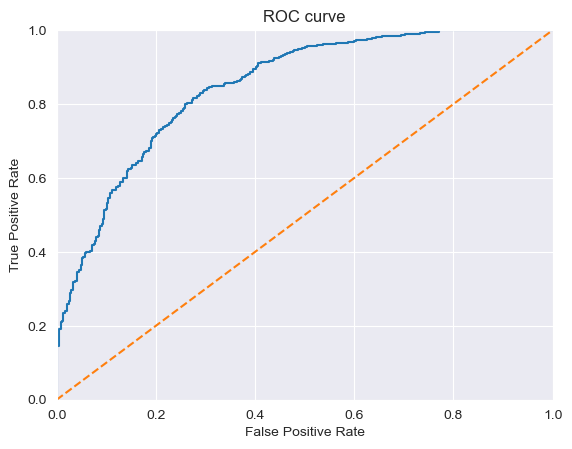

In [112]:
auc_roc(knn_clf, features_valid, target_valid)

**Decision Tree**

In [114]:
%%time
#initialize model
dt = DecisionTreeClassifier(random_state=12345)

#parameter grid
dt_params = {'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy", "log_loss"],
    'splitter': ['best', 'random']       
            }
#grid search
dt_clf = GridSearchCV(dt, param_grid=dt_params, cv=4, n_jobs=-1, verbose=1, scoring='roc_auc')
dt_clf.fit(upsample_features_train, upsample_target_train)

Fitting 4 folds for each of 150 candidates, totalling 600 fits
CPU times: total: 1.61 s
Wall time: 4.43 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'splitter': ['best', 'random']},
             scoring='roc_auc', verbose=1)

In [116]:
print("Tuned Hyperparameters :", dt_clf.best_params_)
print("Accuracy :",dt_clf.best_score_)

Tuned Hyperparameters : {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'splitter': 'best'}
Accuracy : 0.9086104080890417


AUC - ROC Score: 0.8097294624969587
Accuracy Score for the Training Set: 0.7981520966595593


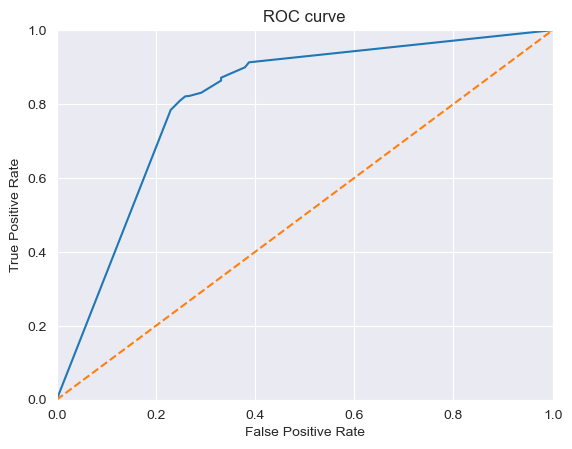

In [118]:
auc_roc(dt_clf, features_valid, target_valid)

**Random Forest**

In [121]:
%%time
#initialize rf model
rf = RandomForestClassifier(random_state=12345)

#parameter grid
rf_params = {
    'n_estimators': [ 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

rf_clf = GridSearchCV(rf, param_grid=rf_params, scoring='roc_auc', cv=3)
rf_clf.fit(upsample_features_train, upsample_target_train)

CPU times: total: 2min 13s
Wall time: 2min 17s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [123]:
print("Tuned Hyperparameters :", rf_clf.best_params_)
print("Accuracy :",rf_clf.best_score_)

Tuned Hyperparameters : {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy : 0.9825933039294344


AUC - ROC Score: 0.8957245135139332
Accuracy Score for the Training Set: 0.8578535891968728


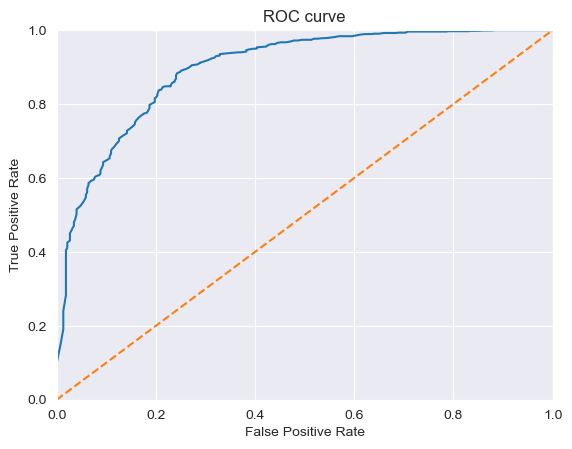

In [125]:
auc_roc(rf_clf, features_valid, target_valid)

### Boosting Models

**XGB**

In [127]:
%%time
#initialize the xgb model
xgb = XGBClassifier(random_state=12345)

xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5, 10],
    'subsample': [0.5, 0.7, 1]
}

xgb_clf = GridSearchCV(xgb, xgb_params, cv=3, scoring='roc_auc')
xgb_clf.fit(upsample_features_train, upsample_target_train)

CPU times: total: 15min 19s
Wall time: 2min 13s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=12345, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 0.7, 1]},
             scoring='roc_auc')

In [129]:
print("Tuned Hyperparameters :", xgb_clf.best_params_)
print("Accuracy :",xgb_clf.best_score_)

Tuned Hyperparameters : {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300, 'subsample': 1}
Accuracy : 0.9856617592987685


AUC - ROC Score: 0.9195893793581853
Accuracy Score for the Training Set: 0.8813077469793887


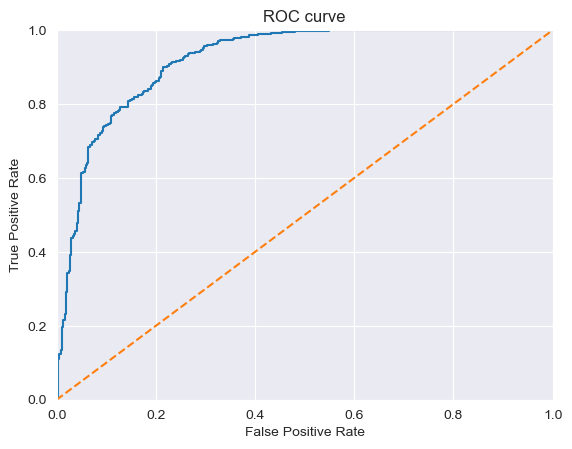

In [131]:
auc_roc(xgb_clf, features_valid, target_valid)

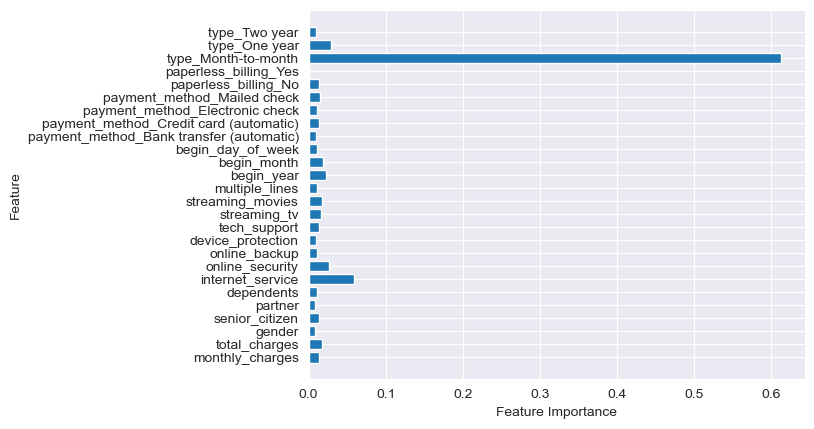

In [61]:
#feature Importance
feat_imp = xgb_clf.best_estimator_.feature_importances_
plt.barh(range(len(feat_imp)), feat_imp)
plt.yticks(range(len(feat_imp)), features_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

**Light GBM**

In [63]:
%%time
#initialize the lgbm model
lgbm = LGBMClassifier(random_state=12345)

#parameter grid
lgbm_params = {
    'boosting_type': ['gbdt', 'dart', 'rf'],
    'num_leaves': [1, 5, 10, 20, 50],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5, 0.75, 1],
    'feature_fraction': [0.1, 0.2, 0.5, 0.75, 1],
    'max_depth': [1, 5, 10, 20, 50],
    'min_data_in_leaf': [10, 25, 50, 100],
}

#grid search
lgbm_clf = GridSearchCV(lgbm, lgbm_params, scoring='roc_auc', cv=3, verbose=2)
#lgbm_clf.fit(upsample_features_train, upsample_target_train) #took appx 1 hour to train

CPU times: total: 0 ns
Wall time: 0 ns


In [64]:
#print("Tuned Hyperparameters :", lgbm_clf.best_params_)
#print("Accuracy :",lgbm_clf.best_score_)

Light GBM: 

Tuned Hyperparameters : {'boosting_type': 'gbdt', 'feature_fraction': 1, 'learning_rate': 0.5, 'max_depth': 50, 'min_data_in_leaf': 10, 'num_leaves': 50}

Accuracy : 0.989400526359771

In [65]:
#auc_roc(lgbm_clf, features_valid, target_valid)

Light GBM:

AUC - ROC Score: 0.9189008702134379
Accuracy Score for the Training Set: 0.8834399431414357

### Final Model: XGBM

In [135]:
#final parameter grid
final_params = {
    'learning_rate': 0.2, 
    'max_depth': 10, 
    'n_estimators': 300, 
    'subsample': 1
}

#initialize final model
fin_model = XGBClassifier(**final_params, random_state=12345)

#train final model
fin_model.fit(upsample_features_train, upsample_target_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=12345, ...)

In [137]:
#predict final model
target_pred = fin_model.predict(features_test)
target_pred_proba = fin_model.predict_proba(features_test)[:, 1]

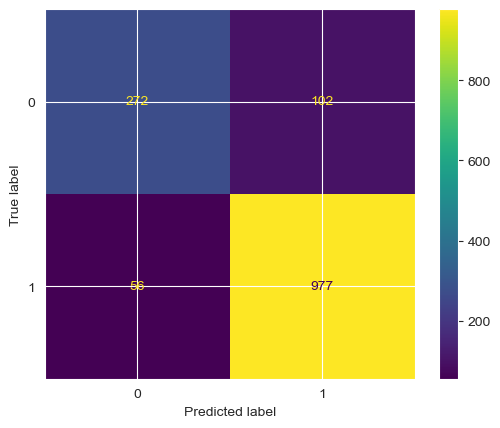

In [139]:
#confusion matrix
cm = confusion_matrix(target_test, target_pred, labels=fin_model.classes_)

#plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fin_model.classes_)
disp.plot()
plt.show()

In [141]:
#auc roc score for final model
print('AUC-ROC Score for Final Model:', roc_auc_score(target_test, target_pred_proba))
print('')


AUC-ROC Score for Final Model: 0.9188762806011254



AUC - ROC Score: 0.9188762806011254
Accuracy Score for the Training Set: 0.8877043354655295


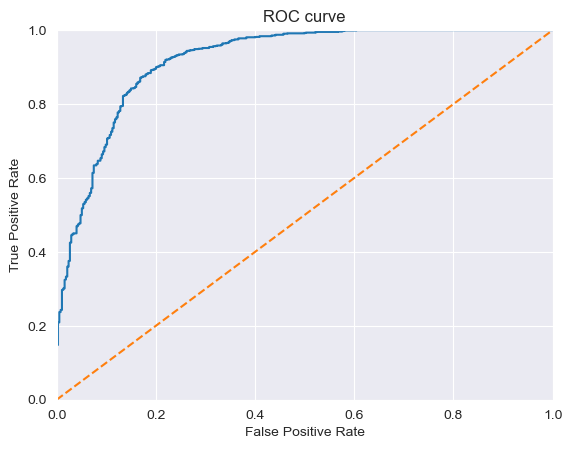

In [143]:
auc_roc(fin_model, features_test, target_test)

## Conclusion

**Overview:** 
<br>
The problem set forth at the beginning of the project was to identify which interconnect customers are most likely to churn based on the data available. This was done through optimization of the right machine learning model which yielded the highest AUC-ROC score. 

**Difficulties Encountered:**
<br>
The first difficulty enroute to getting the data ready for model testing was a large class imbalance in the target class. This was dealt with through an upsampling of the data. It is possible however, that during cross-validation the metrics were slightly inflated due to said oversampling. Upon second pass, I would employ the imblearn pipeline library as the chosen method of resampling to remedy this.

**Steps:**
<br>
1. The first step taken in the project was to **preprocess the data**. This was done by dealing with missing values, merging dataframes, renaming columns, dropping columns unnecessary for analysis, and, finally, encoding the large proportion of categorical variables using a combination of label encoding & one hot encoding. 

2. I performed **exploratory data analysis (EDA)** on the preprocessed data to look for meaningful relationships and correlations between features. 
    
     - One of the highlights was that a large proportion of senior citizens were leaving interconnect. 
     - Higher total charges did not correlate with a high rate of customer churn.
     - Customers who had signed up for fiber optic service experienced a higher churn rate when compared to those with DSL.
     - The large majority of categorical features had somewhat balanced classes.
     
3. **Feature engineering:** New features were extracted from the begin date column, representing begin day of week, begin year, and begin month with the interconnect service. Additionally, categorical features were encoded while numerical features were scaled to prepare for model training. 

4. The fourth step in the process was to conduct **training and tuning** on several models to find the highest AUC-ROC score. This score represents the models ability, between 0 and 1, to distinguish between customers who churn and those who don't churn. Using GridSearchCV, a variety of models were trained on the training set while hyperparameters were tuned to opimize each model's performance. 

5. Once I identified XGBoost as the model the highest comparible AUC-ROC score, I ran the model on the **Final Test Set** using the optimized parameters.

**Final Thoughts for Interconnect:**
Interconnect could use the results of the EDA along with the predictions of the final model to provide special offers to target demographics, such as senior citizens and fiber optic subscibers (those found most likely to churn during EDA). This could be done by offering discounts on certain services, promotions on others, and possibly targeted rewards for customer loyalty. 